# Сборный проект. Яндекс практикум
## Описание проекта
Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, *Xbox* или *PlayStation*). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

## Описание данных games.csv
* Name — название игры
* Platform — платформа
* Year_of_Release — год выпуска
* Genre — жанр игры
* NA_sales — продажи в Северной Америке (миллионы долларов)
* EU_sales — продажи в Европе (миллионы долларов)
* JP_sales — продажи в Японии (миллионы долларов)
* Other_sales — продажи в других странах (миллионы долларов)
* Critic_Score — оценка критиков (от 0 до 100)
* User_Score — оценка пользователей (от 0 до 10)
* Rating — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

## Цель
Выявить закономерности, определяющие успешность игры.

Для начала импортируем необходимые библиотеки и считаем датасет.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st

In [2]:
games = pd.read_csv('./datasets/games.csv')

## Подготовка данных

Взглянем на данные и информацию и них.

In [3]:
games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В глаза бросаются следующие недочёты:
* Названия столбцов не приведены к единому стилю
* Столбец с годами имеет тип вещественного числа
* Столбец с оценкой пользователя имеет строковый тип
* Наличие пропусков

Будем исправлять.

Сначала подкорректируем названия столбцов.

In [5]:
new_columns = [col.lower() for col in games.columns]
new_columns

['name',
 'platform',
 'year_of_release',
 'genre',
 'na_sales',
 'eu_sales',
 'jp_sales',
 'other_sales',
 'critic_score',
 'user_score',
 'rating']

In [6]:
games.columns = new_columns

Изучим столбец с годами. Нужно понять, почему он имеет вещественный тип.

In [7]:
games['year_of_release'].unique()

array([2006., 1985., 2008., 2009., 1996., 1989., 1984., 2005., 1999.,
       2007., 2010., 2013., 2004., 1990., 1988., 2002., 2001., 2011.,
       1998., 2015., 2012., 2014., 1992., 1997., 1993., 1994., 1982.,
       2016., 2003., 1986., 2000.,   nan, 1995., 1991., 1981., 1987.,
       1980., 1983.])

Ни один из годов в таблице не имеет дробную часть. Вероятно, это ошибка сбора или хранения данных. Приведем столбец к целочисленному типу.

In [8]:
try:
    games['year_of_release'] = games['year_of_release'].astype('int')
except:
    print('Error')

Error


Из-за наличия nan мы столкнулись с ошибкой при преобразовании типа. Значит, стоит немного отвлечься от типов данных и разобраться с пропусками в данных.

Видим, что у каких-то двух записей пропущено название игры. Взглянем на эти строки.

In [9]:
games[games['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


В этих строчках нет ни названий игры, ни ее жанра, ни оценок пользователей. Эти две записи вряд ли будут полезны в дальнейшем исследовании, поэтому избавимся от них.

In [10]:
games.dropna(subset=['name'], inplace=True)

In [11]:
games[games['name'].isna()]['name'].count()

0

Теперь разберемся с пропусками в годах. Посмотрим, сколько их.

In [12]:
games[games['year_of_release'].isna()]['name'].count()

269

Год выхода игры необходим для дальнейшего исследования. Заполнить 269 пропусков вручную мы не сможем. Это долго, и в этом нет смысла, так как по сравнению с 16000 игр 269 игры - ничто. Поэтому от строк с пропущенным годом мы тоже избавимся.

In [13]:
games.dropna(subset=['year_of_release'], inplace=True)

In [14]:
games[games['year_of_release'].isna()]['name'].count()

0

Посмотрим на текущую информацию о датасете.

In [15]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  float64
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     7983 non-null   float64
 9   user_score       9839 non-null   object 
 10  rating           9768 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.5+ MB


Осталось разобратсья с тремя колонками. Начнем с рейтинга. Посмотрим, какие значения там могут быть.

In [16]:
games['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Так как рейтинг - не ключевой параметр в исследовании, то просто заменим отсутствующие значения на Unknown.

In [17]:
games['rating'] = games['rating'].fillna('Unknown')

In [18]:
games[games['rating'].isna()]['name'].count()

0

Перейдем к оценкам критиков. Пропусков в них довольно много, поэтому мы не можем просто удалить их. Заполнять их чем-то тоже не стоит - это может привести к искажениям при дальнейшем анализе. Поэтому заполним пропуски значением -1.

In [19]:
games['critic_score'] = games['critic_score'].fillna(-1)

Наконец, изучим столбец user_score. Нужно понять, почему он распознался как строковый.

In [20]:
games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

У нас есть какое-то непонятное значение *tbd*. Посмотрим, насколько часто оно встречается.

In [21]:
games.query('user_score == "tbd"')['name'].count()

2376

Довольно часто. Придётся разобраться, что это означает.

Погуглив, я выяснил, что TBD - это аббревиатура, означающая 'To be determined' или 'To be decided'. То есть, это те игры, оценки к которым еще не определены. Поэтому можно приравнять tbd к nan.

Теперь приведем этот столбец к численному типу данных. Воспользуемся аргументом errors='coerce'. Благодаря ему все tbd првератятся в nan. Затем мы просто сможем заменить все пропуски на -1 (как и в оценках критиков).

In [22]:
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce')
games['user_score'] = games['user_score'].fillna(-1)

Не забудем про столбец с годами. Вернемся к нему и преобразуем его тип.

In [23]:
try:
    games['year_of_release'] = games['year_of_release'].astype('int')
except:
    print('Error')

Теперь все прошло без ошибок.

На всякий случай проверим наличие дубликатов.

In [24]:
games.duplicated().sum()

0

Отлично, дубликатов нет. Взглянем на информацию о данных.

In [25]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16444 non-null  object 
 2   year_of_release  16444 non-null  int32  
 3   genre            16444 non-null  object 
 4   na_sales         16444 non-null  float64
 5   eu_sales         16444 non-null  float64
 6   jp_sales         16444 non-null  float64
 7   other_sales      16444 non-null  float64
 8   critic_score     16444 non-null  float64
 9   user_score       16444 non-null  float64
 10  rating           16444 non-null  object 
dtypes: float64(6), int32(1), object(4)
memory usage: 1.4+ MB


Единственная оставшаяся проблема - пропущенные индексы. Исправим.

In [26]:
games.reset_index(inplace=True)

In [27]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16444 entries, 0 to 16443
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   index            16444 non-null  int64  
 1   name             16444 non-null  object 
 2   platform         16444 non-null  object 
 3   year_of_release  16444 non-null  int32  
 4   genre            16444 non-null  object 
 5   na_sales         16444 non-null  float64
 6   eu_sales         16444 non-null  float64
 7   jp_sales         16444 non-null  float64
 8   other_sales      16444 non-null  float64
 9   critic_score     16444 non-null  float64
 10  user_score       16444 non-null  float64
 11  rating           16444 non-null  object 
dtypes: float64(6), int32(1), int64(1), object(4)
memory usage: 1.4+ MB


Теперь наш датасет готов к анализу.

Так как мы будем исследовать продажи игр, то для удобства добавим столбец с суммарными продажами.

In [28]:
games['total_sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales']

In [29]:
games.head()

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,Unknown,40.24
2,2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,Unknown,31.38


**Вывод**. Провели исследование датасета на предмет ошибок, пропусков и неточностей. Все проблемы, которые могли бы помешать исследованию, устранены. Датасет подготовлен к работе.

## Исследовательский анализ данных

Посмотрим, сколько игр выпускалось в разные годы. Для этого создадим сводную таблицу и на ее основе построим столбчатую диаграмму.

In [30]:
games_per_year = games.pivot_table(index='year_of_release', values='name', aggfunc='count')
games_per_year.columns = ['number_of_games']
games_per_year

,number_of_games
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


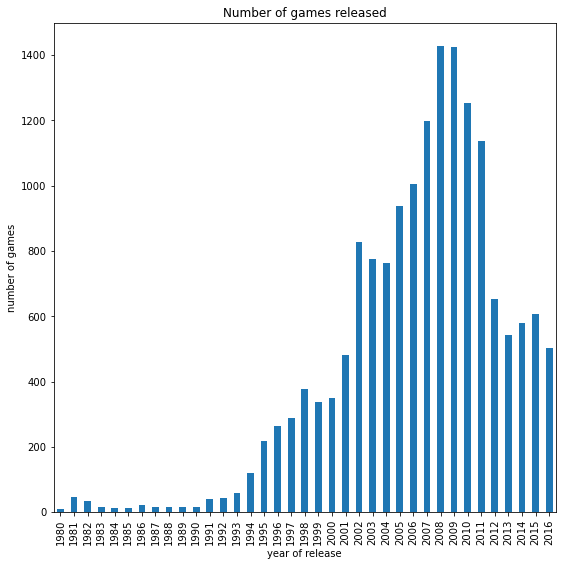

In [31]:
games_per_year.plot(kind='bar', figsize=(9, 9), legend=None)
plt.xlabel('year of release')
plt.ylabel('number of games')
plt.title('Number of games released')
plt.show()
None

Видим, что до 1994 года количество выпускаемых игр в год было сравнительно невелико. Неудивительно, ведь тогда еще только начинали появляться консоли. Однако после 1994 года игры становились все более и более популярными и их количество становилось все больше и больше.

Но после 2011 года произошел резкий спад в количестве новых игр. В 2009-2011 годах начала активно развиваться индустрия мобильных игр. Вероятно, часть компаний перешла именно на мобильные устройства, данные о которых не представлены в датасете.

Данные до 1994 года нам не сильно важны, поэтому можно спокойно их отбросить.

In [32]:
games = games.query('year_of_release >= 1994')

In [33]:
games.shape

(16079, 13)

Теперь посмотрим, как менялись продажи по платформам. Будем исследовать платформы с наибольшими суммарными продажами. Найдем такие платформы.

In [34]:
platforms = games.pivot_table(index='platform', values='total_sales', aggfunc='sum').sort_values(by='total_sales', ascending=False)
platforms

,total_sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.76
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


Возьмем первые 10 платформ полученного топа и построим для них распределение по годам.

In [35]:
top_platforms = list(platforms.head(10).index)
top_platforms

['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', 'GBA', 'PSP', '3DS']

In [36]:
platform_games_per_year = games.pivot_table(index='platform', values='total_sales', columns='year_of_release', aggfunc='sum')
platform_games_per_year = platform_games_per_year.query('index in @top_platforms')
platform_games_per_year

year_of_release,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
platform,,,,,,,,,,,,,,,,,,,,,
3DS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,63.20,51.36,56.57,43.76,27.78,15.14
DS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,146.94,145.31,119.54,85.02,26.18,11.01,1.54,NaN,NaN,NaN
GBA,NaN,NaN,NaN,NaN,NaN,NaN,0.07,61.53,74.16,56.67,...,3.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PS,6.03,35.96,94.7,136.17,169.49,144.53,96.37,35.59,6.67,2.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PS2,NaN,NaN,NaN,NaN,NaN,NaN,39.17,166.43,205.38,184.31,...,75.99,53.90,26.40,5.64,0.45,NaN,NaN,NaN,NaN,NaN
PS3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,73.19,118.52,130.93,142.17,156.78,107.36,113.25,47.76,16.82,3.60
PS4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,25.99,100.00,118.90,69.25
PSP,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,46.93,34.55,37.78,35.04,17.82,7.69,3.14,0.24,0.12,NaN
Wii,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,152.77,171.32,206.97,127.95,59.65,21.71,8.59,3.75,1.14,0.18


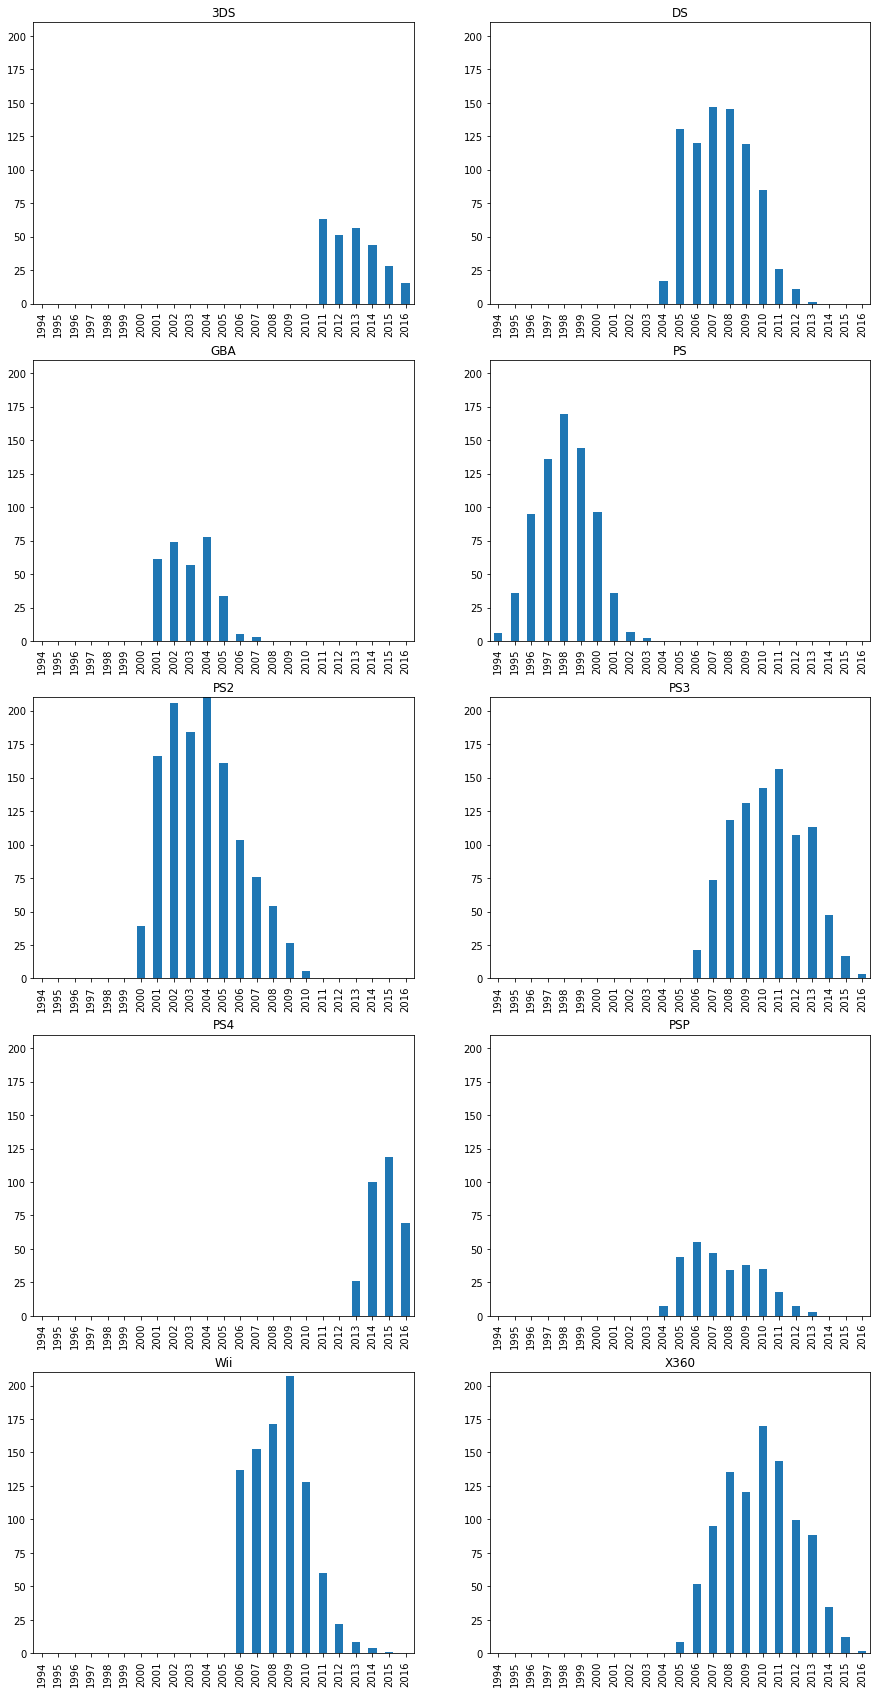

In [37]:
plt.figure(figsize=(15, 30))

for i, platform in enumerate(platform_games_per_year.index):
    plt.subplot(5, 2, i+1)
    plt.title(platform)
    platform_games_per_year.loc[platform, :].plot(kind='bar')
    plt.xlabel('')
    plt.ylim(0, 210)

Можно заметить, что среднее "время жизни" платформы составляет 10 лет. После этого аудиотория переключается на более новые и более продвинутые платформы. Исключение - вечно живой ПК, который используется для игр не так часто, но зато практически постоянно.

Так можно выделить следующие популярные в прошлом платформы, продажи которых сейчас на нуле:
* DS
* GBA
* PS
* PS2
* PSP
* Wii

Так как нас интересует именно текущая ситуация на рынке игр, а резкий спад платформы может произойти буквально за 3 года, то мы будем рассматривать данные, начиная с 2014 года. Так мы будем максимально объективны в обнаружении закономерностей для следующего периода.

In [38]:
games = games.query('year_of_release >= 2014')

In [39]:
games.shape

(1689, 13)

Посмотрим, какие платформы у нас остались.

In [40]:
games['platform'].unique()

array(['PS4', '3DS', 'XOne', 'WiiU', 'PS3', 'X360', 'PC', 'Wii', 'PSV',
       'PSP'], dtype=object)

In [41]:
top_platforms = list(games['platform'].unique())

Выясним, какие платформы лидируют по продажам, какие - растут и какие - падают.

In [42]:
recent_platform_games_per_year = games.pivot_table(index='platform', values='total_sales', columns='year_of_release', aggfunc='sum')
recent_platform_games_per_year

year_of_release,2014,2015,2016
platform,,,
3DS,43.76,27.78,15.14
PC,13.28,8.52,5.25
PS3,47.76,16.82,3.60
PS4,100.00,118.90,69.25
PSP,0.24,0.12,NaN
PSV,11.90,6.25,4.25
Wii,3.75,1.14,0.18
WiiU,22.03,16.35,4.60
X360,34.74,11.96,1.52


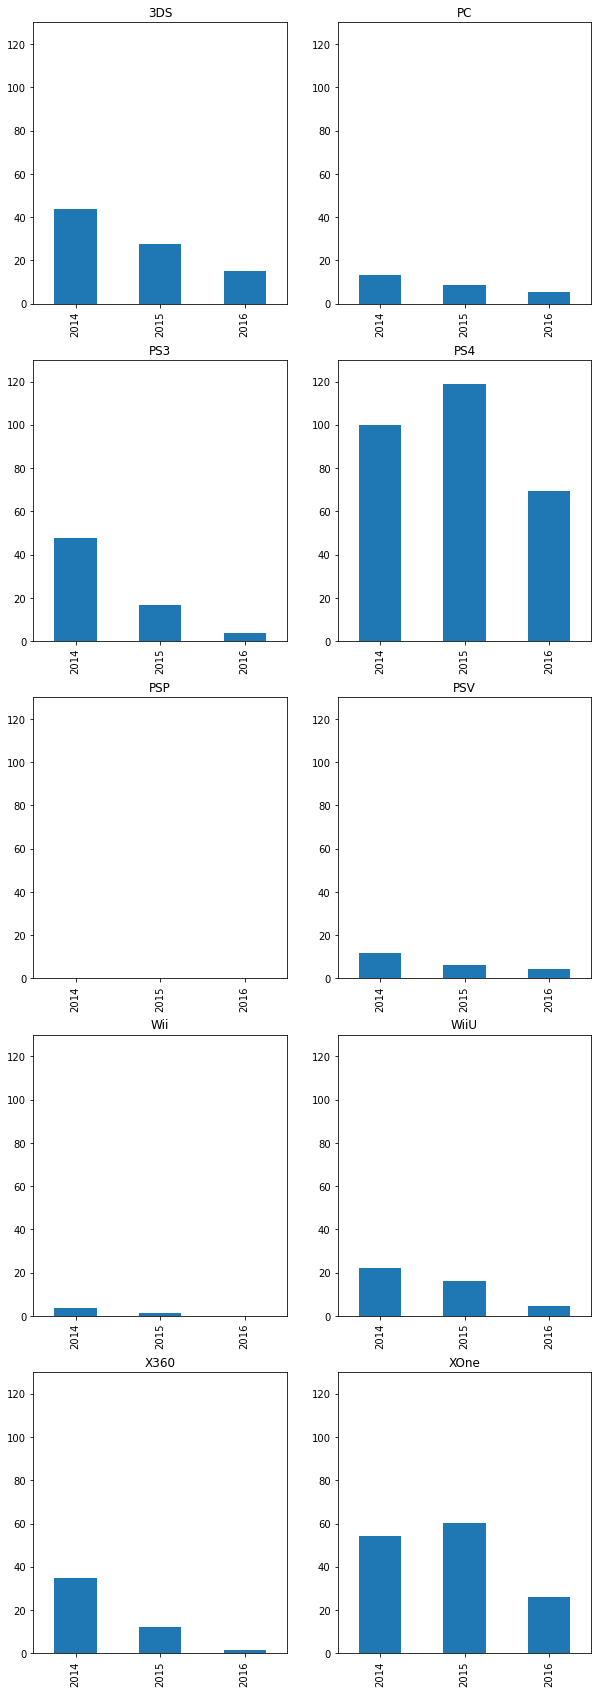

In [43]:
plt.figure(figsize=(10, 30))

for i, platform in enumerate(recent_platform_games_per_year.index):
    plt.subplot(5, 2, i+1)
    plt.title(platform)
    recent_platform_games_per_year.loc[platform, :].plot(kind='bar')
    plt.xlabel('')
    plt.ylim(0, 130)

По построенным гистограммам можно сказать, что ни у одной платформы не наблюдается рост продаж. Рынок игр падает.

Наиболее успешными платформами остаются:
* PS4
* XOne
* 3DS

Будем считать их потенциально прибыльными.

Построим график "ящик с усами" для суммарных продаж игр.

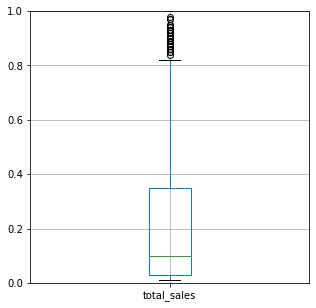

In [44]:
games.boxplot('total_sales', figsize=(5, 5))
plt.ylim(0, 1)
None

Медианное значение продаж игр составляет примерно 0.1 млн долларов.

Теперь построим аналогичные графики отдельно для каждой платформы.

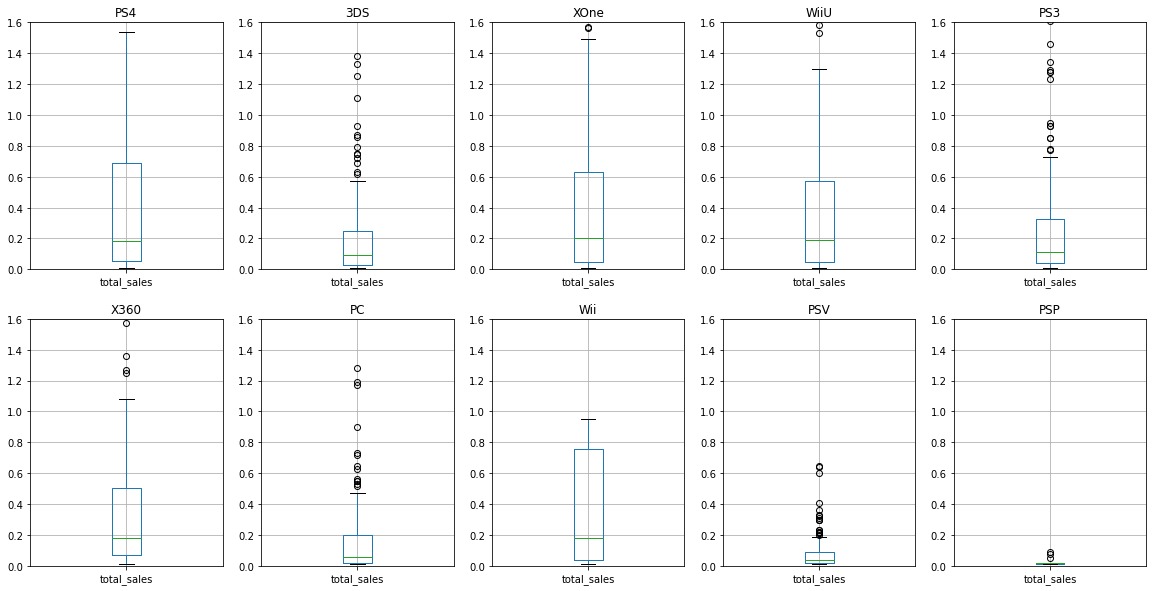

In [45]:
plt.figure(figsize=(20, 10))

for i, platform in enumerate(top_platforms):
    plt.subplot(2, 5, i+1)
    plt.title(platform)
    games.query('platform == @platform').boxplot('total_sales', figsize=(8, 8))
    plt.ylim(0, 1.6)

Медианное значение продаж у большинства платформ варьируется от 0.1 до 0.2 млн долларов. Исключение составляют платформы PSP, PSV (которые остаются популярными лишь в малом числе регионов) и PC (игры для которого уже не так популярны из-за наличия консолей и смартфонов).

По верхнему усу выделяются всеми известные платформы PS4, XOne, WiiU, что неудивительно - они популярнее, продажи игр на них больше.

Теперь посмотрим, как влияют на продажи отзывы пользователей и критиков. Изучим это на примере самой популярной платформы PS4. Построим диаграмму рассеяния между отзывами и продажами.

In [46]:
games_ps4_user = games.query('platform == "PS4" & user_score != -1')
games_ps4_critic = games.query('platform == "PS4" & critic_score != -1')

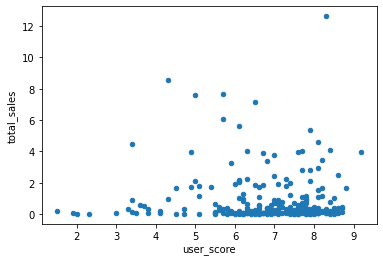

In [47]:
games_ps4_user.plot(x='user_score', y='total_sales', kind='scatter')
None

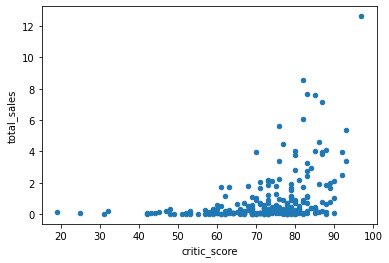

In [48]:
games_ps4_critic.plot(x='critic_score', y='total_sales', kind='scatter')
None

Видно, что игры с высоким рейтингом критиков имеют более высокий показатель продаж. Аналогично можно сказать и про рейтинг игроков, но там гораздо больше выбросов. Ведь не всегда игроки должным образом подходят к оцениванию продукта.

Подтвердим эту мысль, рассчитав корреляцию.

In [49]:
games_ps4_user['total_sales'].corr(games_ps4_user['user_score'])

-0.040131589472697356

In [50]:
games_ps4_critic['total_sales'].corr(games_ps4_critic['critic_score'])

0.40266141068104083

Коэффициенты корреляции подтвердили, что оценка критиков влияет на суммарные продажи, в то время как оценки пользователей практически ни на что не влияют. Пользователи больше доверяют критикам, а не игрокам.

Наконец, посмотрим на общее распределение игр по жарнам.

In [51]:
games_by_genre = games.pivot_table(index='genre', values='total_sales', aggfunc='sum')
games_by_genre

,total_sales
genre,
Action,199.36
Adventure,17.55
Fighting,28.22
Misc,37.55
Platform,18.09
Puzzle,2.21
Racing,27.52
Role-Playing,101.44
Shooter,170.94


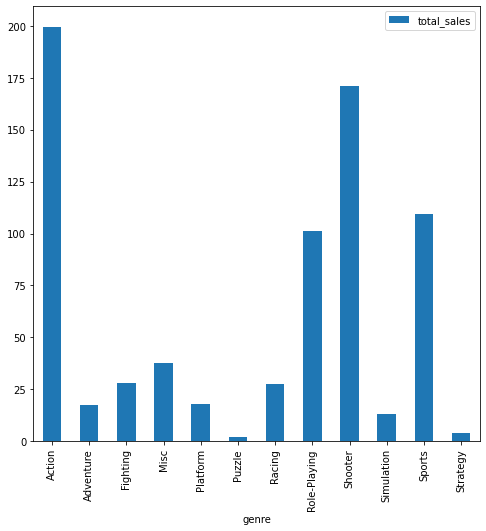

In [52]:
games_by_genre.plot(kind='bar', figsize=(8, 8))
None

По построенной диаграмме видно, что самыми прибыльными жанрами являются Action, Shooter, Sports и Role-Playing. Причем экшены и шутеры сильно выделяются. Наименее же прибыльными жанрами являются Puzzle, Strategy, Adventure. Игры, где надо думать, не очень популярны среди пользователей. Ненапряжные стрелялки заходят лучше.

## Портрет пользователя

Составим портрет пользователя каждого региона. Определим, какие платформы и жанры предпочитают игроки в разных частях мира.

Сперва посмотрим на топ-5 платформ в каждом регионе.

In [53]:
top_platforms = games.pivot_table(index='platform', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
top_platforms

,eu_sales,jp_sales,na_sales
platform,,,
3DS,16.12,44.24,22.64
PC,17.97,0.00,7.23
PS3,25.54,11.22,22.05
PS4,130.04,15.02,98.61
PSP,0.00,0.36,0.00
PSV,3.53,14.54,2.52
Wii,2.59,0.00,2.08
WiiU,13.15,7.31,19.36
X360,15.49,0.08,28.30


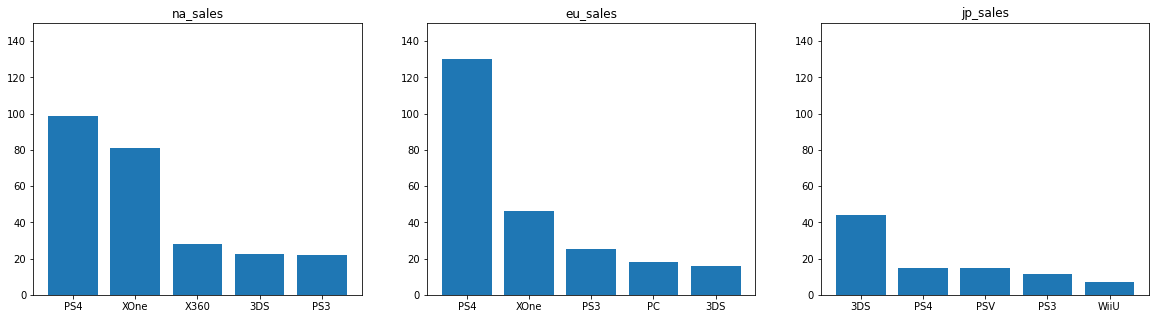

In [54]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(['na_sales', 'eu_sales', 'jp_sales']):
    plt.subplot (1, 3, i+1)
    top_platforms = top_platforms.sort_values(by=col, ascending=False)
    plt.bar(top_platforms.head().index, top_platforms.head()[col])
    plt.title(col)
    plt.ylim(0, 150)
plt.show()

Сейчас в Северной Америке популярны консоли PS3, Xone, X360, 3DS и PS3, причем PS4 и XOne значительно обошли своих конкурентов по продажам. В Европе в топе находятся те же платформы, но вместо X360 европейцы предпочитают персональные компьютеры. В Японии же ситуация другая - там наибольшей популярностью пользуется японская 3DS. Также японцы не против поиграть в популярные во всем мире PS3, PS4 и в не очень популярную сейчас PSV. Завершает топ еще одна японская платформа WiiU.

Теперь посмотрим на жанры, которые предпочитают игроки в разных частях мира.

In [55]:
top_platforms = games.pivot_table(index='genre', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
top_platforms

,eu_sales,jp_sales,na_sales
genre,,,
Action,74.68,29.58,72.53
Adventure,6.49,3.60,5.64
Fighting,6.69,6.37,12.43
Misc,12.86,5.61,15.05
Platform,6.80,2.69,6.79
Puzzle,0.52,0.93,0.65
Racing,14.13,1.76,8.74
Role-Playing,28.17,31.16,33.47
Shooter,65.52,4.87,79.02


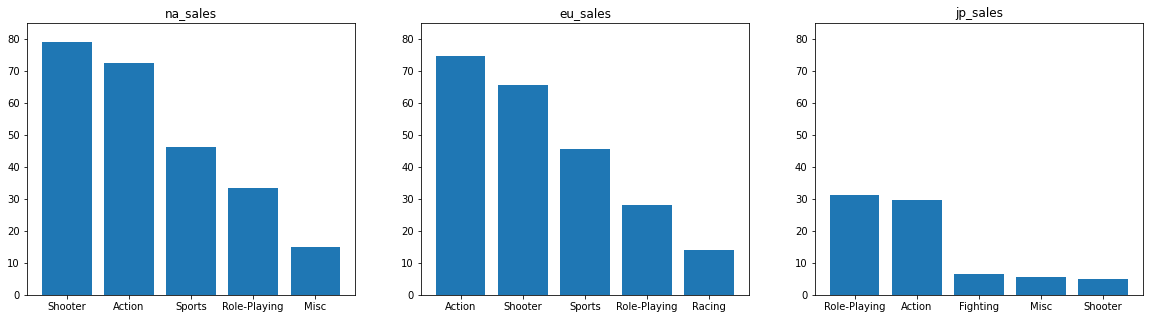

In [56]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(['na_sales', 'eu_sales', 'jp_sales']):
    plt.subplot (1, 3, i+1)
    top_platforms = top_platforms.sort_values(by=col, ascending=False)
    plt.bar(top_platforms.head().index, top_platforms.head()[col])
    plt.title(col)
    plt.ylim(0, 85)
plt.show()

Ситуация в Америке и Европе снова схожая. Игроки предпочитают экшены, шутеры, игры про спорт и ролевые игры. Но на пятом месте в Америке расположились аркады (Misc), а в Европе - гонки. В Японии же ролевые игры вышли на первое место с небольшим отрывом от экшенов. А популярные во всем мире шутеры оказались на последнем месте наравне с Fighting'ами и аркадами.

Япония - довольно необычная страна, ярко выделяющаяся на фоне остальных государств. Культура Японии довольно специфична и необычна. У японцев другие интересы, некоторые из которых кажутся всему остальному миру странными. Поэтому результаты исследования вполне закономерны - вкусы японцев отличаются от предпочтений американцев и европейцев, которые, как и большинство остальных людей, гонятся за мировыми новинками и бестселлерами.

Стоит изучить, как влияет рейтинг ESRB на продажи. Но перед этим стоит разобраться, что же означает этот рейтинг.

In [57]:
games['rating'].unique()

array(['Unknown', 'M', 'E', 'T', 'E10+'], dtype=object)

Согласно википедии, расшифровка этих обозначений следующая:
* E - Everyone - Для всех
* M - Mature - Для взрослых (старше 17 лет)
* E10+ - Everyone 10 and older - Для всех от 10 лет и старше
* T - Teen - Подросткам (старше 13 лет)

Отбросим игры с Unknown и посмотрим на зависимость продаж от рейтинга.

In [58]:
ratings = games.query('rating != "Unknown"').pivot_table(index='rating', values=['na_sales', 'eu_sales', 'jp_sales'], aggfunc='sum')
ratings

,eu_sales,jp_sales,na_sales
rating,,,
E,58.06,8.94,50.74
E10+,26.16,4.46,33.23
M,93.44,8.01,96.42
T,34.07,14.78,38.95


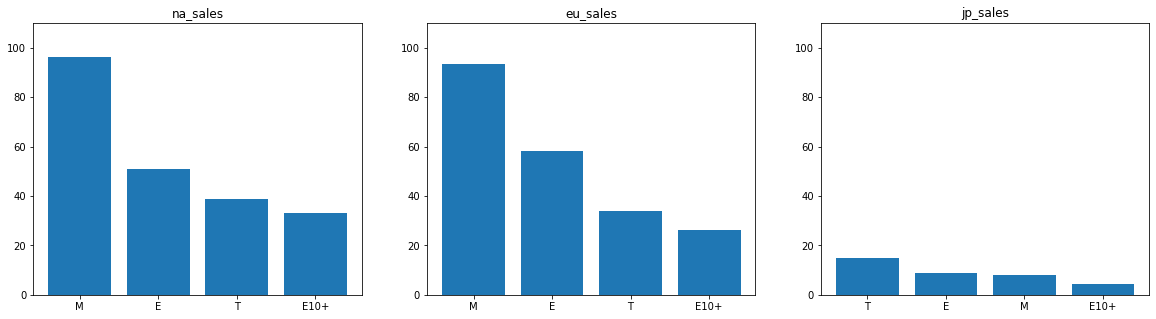

In [59]:
plt.figure(figsize=(20, 5))

for i, col in enumerate(['na_sales', 'eu_sales', 'jp_sales']):
    plt.subplot (1, 3, i+1)
    ratings = ratings.sort_values(by=col, ascending=False)
    plt.bar(ratings.head().index, ratings.head()[col])
    plt.title(col)
    plt.ylim(0, 110)
plt.show()

В Америке и Европе популярнее всего игры "для взрослых" (что не удивительно, ведь к этой категории относится большинство стрелялок). В Японии же популярнее всего оказались подростковые игры. Но есть одна общая закономерность: игры для детей крайне не популярны во всех регионах.

## Исследование статистических показателей

Необходимо изучить распределение рейтинга пользователей и критиков в различных жанрах. Для исследования возьмем следующие жанры:
* Action - как один из самых популярных
* Fighting - как один из самых непопулярных
* Role-Playing - как средний по популярности

In [60]:
games_action = games.query('genre == "Action"')
games_fighting = games.query('genre == "Fighting"')
games_rp = games.query('genre == "Role-Playing"')

Построим гистограммы распределения пользовательского рейтинга и рейтинга критиков

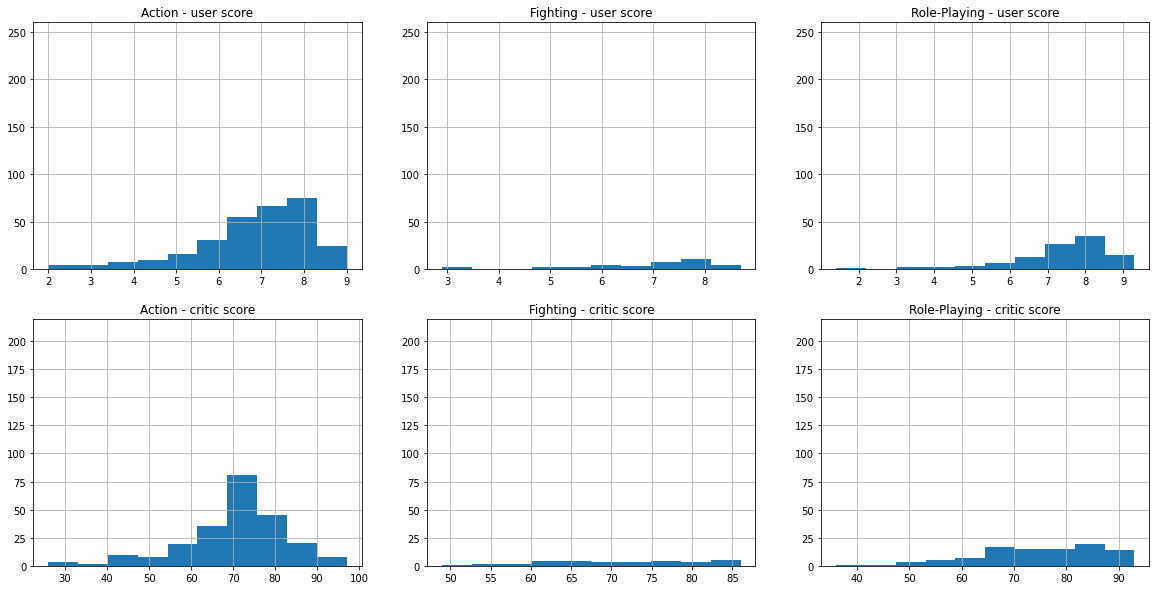

In [61]:
plt.figure(figsize=(20, 10))

for i, genre_df in enumerate([games_action, games_fighting, games_rp]):
    plt.subplot (2, 3, i + 1)
    genre_df.query('user_score >= 0')['user_score'].hist()
    plt.title(genre_df['genre'].values[0] + ' - user score')
    plt.ylim(0, 260)
    
    plt.subplot (2, 3, i + 4)
    genre_df.query('critic_score >= 0')['critic_score'].hist()
    plt.title(genre_df['genre'].values[0] + ' - critic score')
    plt.ylim(0, 220)
    
plt.show()

Судя по гистограммам, мы имеем дело с распределениями, скошенными влево. Рассчитаем медиану, дисперсию и стандартное отклонение.

Для удобства напишем функцию, вычисляющую все статистические показатели.

In [62]:
def get_statistics(df, col):
    cur_column = ''
    if col == 'user':
        cur_column = 'user_score'
    else:
        cur_column = 'critic_score'
    print(genre_df['genre'].values[0] + ' ' + cur_column + ' stats: ')
    cur_df = df.query("user_score >= 0")
    print('mean\t' + str(cur_df[cur_column].mean()))
    print('var\t' + str(np.var(cur_df[cur_column])))
    print('std\t' + str(np.sqrt(np.var(cur_df[cur_column]))))
    print('\n')

In [63]:
for genre_df in [games_action, games_fighting, games_rp]:
    get_statistics(genre_df, 'user')

Action user_score stats: 
mean	6.760606060606054
var	1.8920844811753907
std	1.3755306180435936


Fighting user_score stats: 
mean	6.983783783783784
var	1.768926223520818
std	1.3300098584299358


Role-Playing user_score stats: 
mean	7.348571428571428
var	1.719450340136055
std	1.3112781322572473




In [64]:
for genre_df in [games_action, games_fighting, games_rp]:
    get_statistics(genre_df, 'critic')

Action critic_score stats: 
mean	53.65993265993266
var	1031.5779568978235
std	32.11818732272766


Fighting critic_score stats: 
mean	58.83783783783784
var	776.5682980277572
std	27.866975042651422


Role-Playing critic_score stats: 
mean	68.77142857142857
var	527.5287074829936
std	22.967993109607846




Можно обнаружить сходства в распределении оценок пользователей и критиков по жанрам. 

Медианная оценка пользователей для каждого из рассматриваемых жанров примерно равна 6. Величины дисперсии и стандартного отклонения приближенно равны между собой.

Медианная оценка критиков колеблется от 60 до 70 в зависимости от жанра. Хотя показатели дисперсии этих величин намного отличаются друг от друга, стандартное отклонение (корень из дисперсии) снова получилось почти одинаковым.

Из полученных результатов можно сделать вывод, что критики чаще всего выставляют оценки от 60 до 70, а пользователи - оценку 7.

## Проверка гипотез

Необходимо проверить две гипотезы. Будем использовать пороговое значение alpha = 0.05. Все рассматриваемые гипотезы являются гипотезами о равенстве средних двух генеральных совокупностей. Поэтому будем использовать функцию scipy.stats.ttest_ind().

**Гипотеза 1**. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

Построим нулевую и альтернативную гипотезы:

**$H_0$**: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые  
**$H_1$**: Средние пользовательские рейтинги платформ Xbox One и PC различаются

(Нулевая гипотеза должна сравнивать на "равно", альтернативная - на "не равно")

In [65]:
xone_rating = games.query('platform == "XOne" and user_score >= 0')['user_score']
pc_rating = games.query('platform == "PC" and user_score >= 0')['user_score']
results = st.ttest_ind(xone_rating, pc_rating)
results.pvalue

0.10450507919348415

Мы не можем отвергнуть нулевую гипотезу, значит средние пользовательские рейтинги платформ одинаковые. Проверим это, рассчитав средние значения.

In [66]:
pc_rating.mean()

6.298360655737703

In [67]:
xone_rating.mean()

6.594545454545453

Они действительно очень близки. Подтверждаем гипотезу. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.

**Гипотеза 2**. Средние пользовательские рейтинги жанров Action и Sports разные.

Построим нулевую и альтернативную гипотезы:

**$H_0$**: Средние пользовательские рейтинги жанров Action и Sports одинаковые.  
**$H_1$**: Средние пользовательские рейтинги жанров Action и Sports различаются.

In [68]:
action_rating = games.query('genre == "Action" and user_score >= 0')['user_score']
sports_rating = games.query('genre == "Sports" and user_score >= 0')['user_score']
results = st.ttest_ind(action_rating, sports_rating)
results.pvalue

2.8711147985105864e-19

Полученное значение крайне мало. Отвергаем нулевую гипотезу. Однако исходная гипотеза - альтернативная, значит ее мы подтверждаем. Средние пользовательские рейтинги жанров Action и Sports разные.

## Выводы

Провели исследование продаж игр. Установили следующие закономерности, определяющие успешность игры:
* **Платформа.** На данный момент потенциально прибыльными платформами являются PS4, XOne и 3DS. Хотя все эти платформы находятся на стадии "угасания".
* **Жанр.** Игроки почти во всем мире предпочитают игры жанров Action, Shooter, Sports, Role-Playing. Жанры Strategy, Puzzle, Adventure являются наименее популярными.
* **Возрастное ограничение.** Популярнее всего оказались игры с возрастной категорией "18+". Это конечно же не означает, что в них играют только взрослые люди. Это еще раз подтверждает популярность стрелялок, ведь большинство из них как раз предназначены только для совершеннолетних игроков.
* **Рейтинг.** Оценки критиков сильно влияют на продажи игр. Оценки пользователей же почти никакого влияния не оказывают.

В целом рынок игр падает. Большинство производителей игр переключились на более доступные, а следовательно и более популярные устройства - смартфоны. Люди не хотят покупать консоль и игру для этой консоли, если есть аналогичная игра на телефон, который сейчас есть у каждого. Поэтому можно отметить, что популярность мобильных приложений и игр будет только расти.